Bounding Box in Original CRS (EPSG:32615): 441199.0, 6774690.8, 450611.0, 6781929.2
Bounding Box in WGS84 (EPSG:4326): -94.09297243750525, 61.10246789140987, -93.91617039289176, 61.16873947033946
Time taken to fetch shoreline data: 4.85 seconds
WFS shoreline data found.
Shoreline data saved to ./output/Land_Features/shoreline_utm.geojson


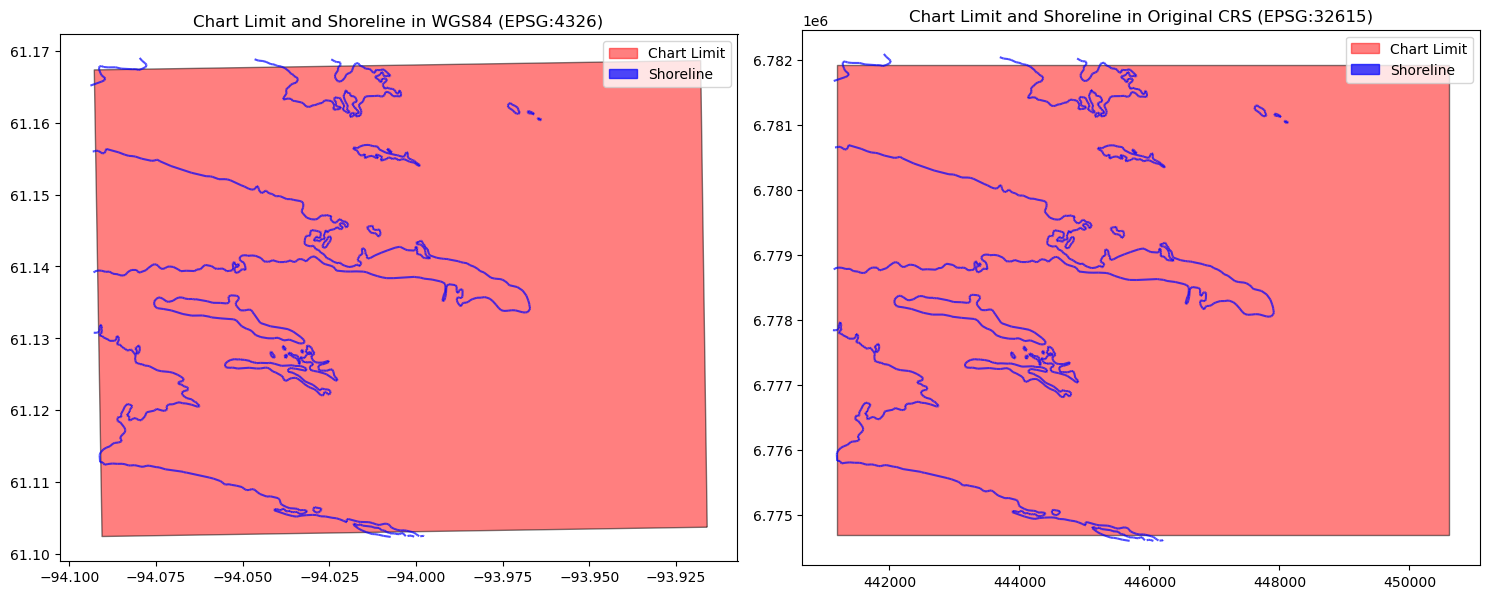

In [ ]:
# Shoreline Data Extraction and Processing Script
#
# This script extracts shoreline data within a given chart limit boundary.
# It first attempts to fetch shoreline features from a **WFS service**.
# If the WFS request fails or returns no data, it falls back to **OSM (Overpass API)**.
# The final shoreline data is saved as a GeoPackage and visualized.
#
# Inputs:
#   - geojson_path: Path to the GeoPackage containing the chart limit boundary.
#
# Outputs:
#   - output_geojson: GeoPackage containing the extracted shoreline features.
#   - A plot visualizing the chart limit and shoreline in both WGS84 and original CRS.
#
# Method:
#   - Reads the **chart limit boundary** from a GeoPackage.
#   - Extracts its bounding box in both **original CRS** and **WGS84**.
#   - Queries **WFS** for shoreline data within the bounding box.
#   - If WFS fails or returns no data, queries **OSM Overpass API** as a fallback.
#   - Converts shoreline geometries to **LineStrings** if necessary.
#   - Saves the extracted shoreline features as a GeoPackage.
#   - Generates **visualizations** in both WGS84 and the original CRS.

import os
import requests
import geopandas as gpd
import matplotlib.pyplot as plt
import time
from shapely.geometry import LineString, Polygon
import json

# -----------------------------------------
# Load Chart Limit Boundary
# -----------------------------------------

# Define the path to the input GeoPackage file
geojson_path = "./output/Chart_Features/chartlimit_utm.geojson"

# Read the Chart Limit GeoPackage
chartlimit_gdf = gpd.read_file(geojson_path)

# Store the original CRS of the dataset
chartlimit_crs = chartlimit_gdf.crs

# Extract the bounding box in the original CRS
minx_orig, miny_orig, maxx_orig, maxy_orig = chartlimit_gdf.total_bounds
print(f"Bounding Box in Original CRS ({chartlimit_crs}): {minx_orig}, {miny_orig}, {maxx_orig}, {maxy_orig}")

# Convert the chart limit to **WGS84 (EPSG:4326)** if needed
chartlimit_gdf_wgs84 = chartlimit_gdf.to_crs("EPSG:4326")

# Extract the bounding box in WGS84
minx_wgs, miny_wgs, maxx_wgs, maxy_wgs = chartlimit_gdf_wgs84.total_bounds
print(f"Bounding Box in WGS84 (EPSG:4326): {minx_wgs}, {miny_wgs}, {maxx_wgs}, {maxy_wgs}")

# -----------------------------------------
# Query WFS for Shoreline Data
# -----------------------------------------

# Construct the WFS request URL using the bounding box
wfs_bbox = [minx_wgs, miny_wgs, maxx_wgs, maxy_wgs]
wfs_url = ()

# Measure the time taken to fetch shoreline data
start_time = time.time()
response = requests.get(wfs_url)
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Time taken to fetch shoreline data: {elapsed_time:.2f} seconds")

shoreline_gdf = None  # Initialize empty GeoDataFrame

# Check if the WFS request was successful
if response.status_code == 200:
    # Load the GeoJSON response into a GeoDataFrame
    shoreline_gdf = gpd.read_file(response.text)
    
    if not shoreline_gdf.empty:
        shoreline_gdf = shoreline_gdf.drop(columns=['id'], errors='ignore')  # Remove unnecessary columns
        print("WFS shoreline data found.")
    else:
        print("WFS request successful but returned no shoreline features.")
else:
    print(f"Failed to fetch shoreline data from WFS. HTTP Status Code: {response.status_code}")

# -----------------------------------------
# Fallback: Query OSM Overpass API if WFS Fails
# -----------------------------------------

if shoreline_gdf is None or shoreline_gdf.empty:
    print("Fetching shoreline data from OSM (Overpass API) as fallback...")

    # Overpass API query for **lakes** within the bounding box
    overpass_url = "https://overpass-api.de/api/interpreter"
    overpass_query = f"""
    [out:json];
    (
      relation["natural"="water"]["type"="multipolygon"]["water"="lake"]
      ({miny_wgs},{minx_wgs},{maxy_wgs},{maxx_wgs});
    );
    out geom;
    """

    response = requests.get(overpass_url, params={"data": overpass_query})

    if response.status_code == 200:
        data = response.json()
        with open('./output/Land_Features/overpass_data_wgs84.json', 'w') as json_file:
            json.dump(data, json_file, indent=4)

        import json
        import osm2geojson
        
        # Convert OSM JSON to GeoJSON
        geojson = osm2geojson.json2geojson(data)
        
        # Save as GeoJSON file
        with open('./output/Land_Features/overpass_data_wgs84.geojson', 'w') as geojson_file:
            json.dump(geojson, geojson_file, indent=4)

        # Convert GeoJSON dictionary directly to a GeoDataFrame
        osm_geojson_gdf = gpd.GeoDataFrame.from_features(geojson["features"])
        
        # Assign the default CRS (EPSG:4326) if it's missing
        if osm_geojson_gdf.crs is None:
            osm_geojson_gdf.set_crs(epsg=4326, inplace=True)
        
        # Convert the CRS to a projected one to get accurate area calculations
        projected_gdf = osm_geojson_gdf.to_crs(epsg=3857)  # Web Mercator projection
    
        # Set the area threshold (e.g., 100 square meters)
        area_threshold = 10000000  # Adjust this value as needed
        
        # Count the total number of polygons before filtering
        total_polygons = len(projected_gdf)
        
        # Filter out small polygons
        large_polygons_gdf = projected_gdf[projected_gdf.geometry.area > area_threshold]
        
        # Count the number of polygons after filtering
        remaining_polygons = len(large_polygons_gdf)
        
        # Calculate the number of polygons that were filtered out
        filtered_out = total_polygons - remaining_polygons
        
        # Print the results
        print(f"Total polygons before filtering: {total_polygons}")
        print(f"Total polygons after filtering: {remaining_polygons}")
        print(f"Number of polygons filtered out: {filtered_out}")
        
        # Convert back to original CRS
        large_polygons_gdf = large_polygons_gdf.to_crs(epsg=4326)
        
        # Save the filtered GeoDataFrame as GeoJSON
        large_polygons_gdf.to_file("./output/Land_Features/filtered_data.geojson", driver="GeoJSON")
    
        # Convert polygons to lines (extract boundaries)
        shoreline_gdf = large_polygons_gdf.copy()
        shoreline_gdf["geometry"] = large_polygons_gdf.boundary
        
        # Save the new GeoDataFrame with LineStrings
        shoreline_gdf.to_file("./output/Land_Features/shoreline.geojson", driver="GeoJSON")
        print("OSM JSON converted, small polygons removed, and saved as shoreline.geojson")

    else:
        print(f"Overpass API request failed: {response.status_code}")

# -----------------------------------------
# Save Shoreline Data if Available
# -----------------------------------------

if shoreline_gdf is not None and not shoreline_gdf.empty:
    # Convert shoreline data to original CRS
    shoreline_gdf_original_crs = shoreline_gdf.to_crs(chartlimit_crs)

    # Define the output GeoPackage file
    output_geojson = "./output/Land_Features/shoreline_utm.geojson"
    if os.path.exists(output_geojson):
        os.remove(output_geojson)
    shoreline_gdf_original_crs.to_file(output_geojson, driver="GeoJSON")
    print(f"Shoreline data saved to {output_geojson}")

    # -----------------------------------------
    # Visualization of Shoreline and Chart Limit
    # -----------------------------------------

    import matplotlib.patches as mpatches
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    
    # Plot chartlimit and shoreline in WGS84
    chartlimit_gdf_wgs84.plot(ax=ax[0], color="red", edgecolor="black", alpha=0.5)
    shoreline_gdf.plot(ax=ax[0], color="blue", edgecolor="black", alpha=0.7)
    ax[0].set_title("Chart Limit and Shoreline in WGS84 (EPSG:4326)")
    
    # Plot in original CRS
    chartlimit_gdf.plot(ax=ax[1], color="red", edgecolor="black", alpha=0.5)
    shoreline_gdf_original_crs.plot(ax=ax[1], color="blue", edgecolor="black", alpha=0.7)
    ax[1].set_title(f"Chart Limit and Shoreline in Original CRS ({chartlimit_crs})")
    
    # Create manual legend handles
    chartlimit_patch = mpatches.Patch(color='red', label='Chart Limit', alpha=0.5)
    shoreline_patch = mpatches.Patch(color='blue', label='Shoreline', alpha=0.7)
    
    # Add legends
    ax[0].legend(handles=[chartlimit_patch, shoreline_patch])
    ax[1].legend(handles=[chartlimit_patch, shoreline_patch])
    
    plt.tight_layout()
    plt.show()

else:
    print("No shoreline data found from either WFS or OSM.")


Shoreline Clip with Chartlimit and Polygon Reconstruction started at: 2025-04-16 17:12:58.284382
Clipping shoreline to extent from chart limit: (441199.0, 6774690.8, 450611.0, 6781929.2)
Clipped shoreline with closed polygons saved to ./output/Land_Features/shoreline_clip_with_chartlimit_utm.geojson


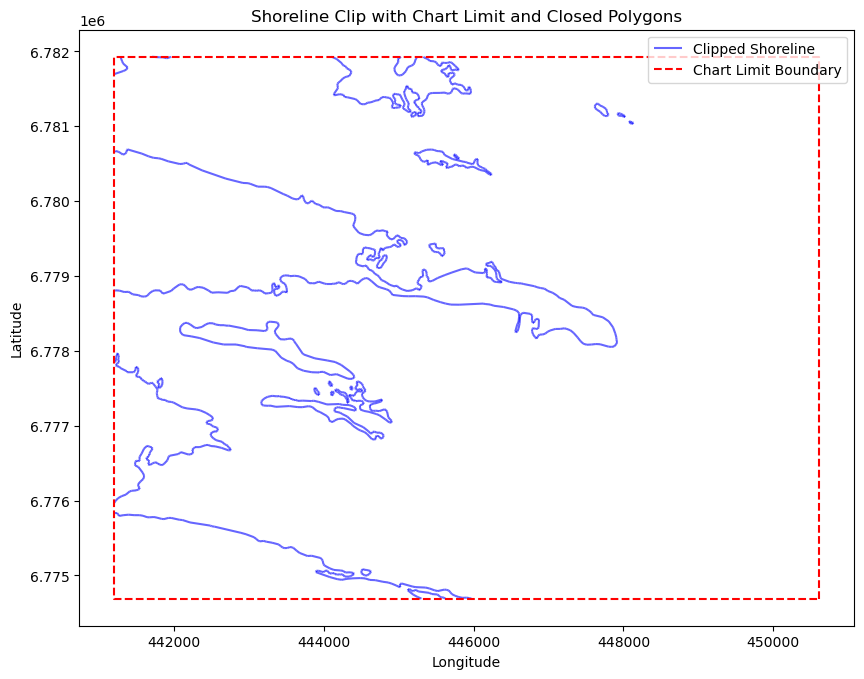

Shoreline Clip with Chartlimit and Polygon Reconstruction completed at: 2025-04-16 17:12:58.661349


In [16]:
# Shoreline Clipping and Polygon Reconstruction Script
#
# This script clips a shoreline GeoDataFrame using a pre-defined chart limit, ensuring geometries are consistent 
# with the chart's extent. It then fixes any polygons intersecting the chart boundary, reconstructs them as needed, 
# and saves the result to a new GeoPackage. The output is visualized with the clipped shoreline and chart boundary.
#
# Inputs:
#   - input_layer: Path to the input GeoPackage containing shoreline geometries with depth.
#   - chartlimit_geojson: Path to the GeoPackage containing the chart limit (extent polygon).
#   - crs: The target Coordinate Reference System (CRS) for the geometries.
#
# Outputs:
#   - output_file: GeoPackage with the clipped shoreline geometries and any fixed polygons.
#   - A plot visualizing the clipped shoreline with the chart boundary.
#
# Method:
#   - shoreline_clip_with_chartlimit()
#
# Reference:
#   - https://github.com/umap-iic/UMap/blob/310d08604aeba3592c50e85dd5eb80ae218459cd/UMap.py#L2185

import os
import geopandas as gpd
from shapely.geometry import box, Polygon, LineString
from shapely.ops import unary_union
from datetime import datetime
import matplotlib.pyplot as plt
import sys

# File paths
input_layer = './output/Land_Features/shoreline_utm.geojson'  # Output from previous task
chartlimit_geojson = './output/Chart_Features/chartlimit_utm.geojson'  # Pre-calculated map extent from previous task
output_file = './output/Land_Features/shoreline_clip_with_chartlimit_utm.geojson'  # Output file for this task

sys.path.insert(1, r'./lib')
from utilities import utm_zone_from_wgs84

# Start task
print(f"Shoreline Clip with Chartlimit and Polygon Reconstruction started at: {datetime.now()}")

# Step 1: Load the input GeoPackage (shoreline with depth)
shoreline_gdf = gpd.read_file(input_layer)

# Step 2: Load the pre-calculated map extent (chart limit) GeoPackage
chartlimit_gdf = gpd.read_file(chartlimit_geojson)

if shoreline_gdf.crs == 'EPSG:4326':
    print(f"Reprojecting shoreline.")
    shoreline_centroid = shoreline_gdf.geometry.unary_union.centroid
    projected_coord_system = utm_zone_from_wgs84(shoreline_centroid.y, shoreline_centroid.x)
    projected_shoreline_gdf = shoreline_gdf.to_crs(projected_coord_system)
elif shoreline_gdf.crs == 'EPSG:3857':
    print(f"Reprojecting shoreline.")
    shoreline_centroid = shoreline_gdf.geometry.unary_union.centroid
    projected_coord_system = utm_zone_from_wgs84(shoreline_centroid.y, shoreline_centroid.x)
    projected_shoreline_gdf = shoreline_gdf.to_crs(projected_coord_system)
else:
    projected_shoreline_gdf = shoreline_gdf
    projected_coord_system = shoreline_gdf.crs

if chartlimit_gdf.crs == 'EPSG:4326':
    print(f"Reprojecting chart limit.")
    projected_chartlimit_gdf = chartlimit_gdf.to_crs(projected_coord_system)
else:
    projected_chartlimit_gdf = chartlimit_gdf

# Step 3: Use the extent from the chart limit GeoPackage as the clipping geometry
clip_geom = projected_chartlimit_gdf.geometry[0]  # Assuming there is one polygon in the GeoPackage

# Ensure the geometries are valid
if projected_shoreline_gdf.empty:
    print("Error: Shoreline GeoDataFrame is empty before clipping.")
else:
    print(f"Clipping shoreline to extent from chart limit: {clip_geom.bounds}")
    
    # Step 4: Perform the clipping operation
    clipped_gdf = projected_shoreline_gdf.clip(clip_geom)

    # Check if clipping returned valid geometries
    if clipped_gdf.empty:
        print(f"Error: Clipping resulted in an empty GeoDataFrame. Check if the input geometries overlap.")
    else:
        # Step 5: Detect geometries that intersect with the bounding box
        bounding_box = projected_chartlimit_gdf.total_bounds
        minx, miny, maxx, maxy = bounding_box

        # Create a bounding box polygon using Shapely
        bbox_polygon = box(minx, miny, maxx, maxy)

        # Step 6: Fix polygons that intersect the bounding box
        def close_boundary(geom, bbox):
            # Ensure we only deal with polygons that touch the boundary
            if geom.intersects(bbox):
                if isinstance(geom, Polygon):
                    # Use the boundary (outer line) to check and fix
                    new_boundary = geom.boundary.intersection(bbox)
                    if isinstance(new_boundary, LineString):
                        return Polygon(list(geom.exterior.coords) + list(new_boundary.coords))
            return geom

        # Apply the boundary fixing function to polygons touching the bounding box
        clipped_gdf['geometry'] = clipped_gdf['geometry'].apply(lambda geom: close_boundary(geom, bbox_polygon))

        # Step 7: Save the result in a GeoPackage
        if os.path.exists(output_file):
            os.remove(output_file)
        clipped_gdf.to_file(output_file, driver="GeoJSON")
        print(f"Clipped shoreline with closed polygons saved to {output_file}")
        
        # Step 8: Plotting the result
        fig, ax = plt.subplots(figsize=(10, 10))
        clipped_gdf.plot(ax=ax, color='blue', edgecolor='black', alpha=0.6, label="Clipped Shoreline")
        projected_chartlimit_gdf.boundary.plot(ax=ax, color='red', linestyle='--', label="Chart Limit Boundary")
        ax.set_title("Shoreline Clip with Chart Limit and Closed Polygons")
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        ax.legend()
        plt.show()

# End task
print(f"Shoreline Clip with Chartlimit and Polygon Reconstruction completed at: {datetime.now()}")



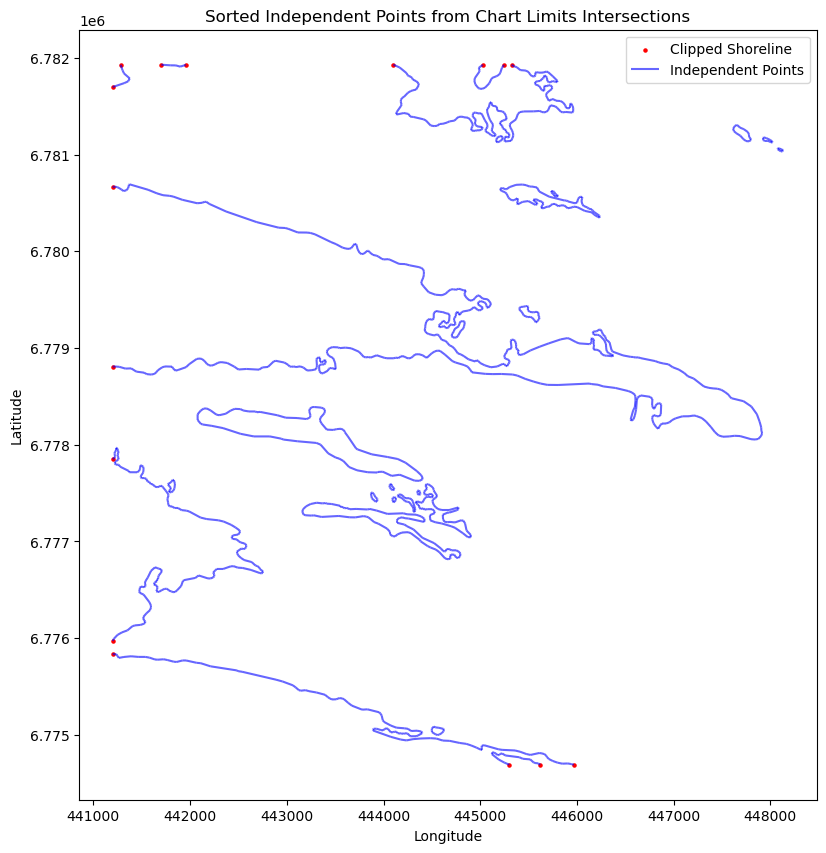

Sorted independent points saved to ./output/Chart_Features/independent_points_intersections_in_order.geojson
Total Points: 16


In [17]:
import os
import geopandas as gpd
from shapely.geometry import LineString, Point
import matplotlib.pyplot as plt

# Input files
clipped_shoreline_file = './output/Land_Features/shoreline_clip_with_chartlimit_utm.geojson'
chart_limits_geojson = './output/Chart_Features/chartlimit_utm.geojson'
output_points_file = './output/Chart_Features/independent_points_intersections_in_order.geojson'

# Load the GeoPackages
clipped_shoreline_gdf = gpd.read_file(clipped_shoreline_file)
chart_limits_gdf = gpd.read_file(chart_limits_geojson)

# Step 1: Load the chart limits and convert the boundary to a LineString
chart_limit_polygon = chart_limits_gdf.geometry[0]
chart_limit_boundary = LineString(chart_limit_polygon.exterior.coords)

# Step 2: Identify intersection points
intersection_points = []

for clipped_geom in clipped_shoreline_gdf.geometry:
    intersection = clipped_geom.intersection(chart_limit_boundary)
    if intersection.is_empty:
        continue
    if isinstance(intersection, Point):
        intersection_points.append(intersection)
    elif intersection.geom_type == "MultiPoint":
        intersection_points.extend([geom for geom in intersection.geoms if isinstance(geom, Point)])
    elif intersection.geom_type == "GeometryCollection":
        intersection_points.extend([geom for geom in intersection if isinstance(geom, Point)])

# Check if intersection points are found
if not intersection_points:
    print("No intersection points were found between the clipped shoreline and the chart limit.")
else:
    # Step 3: Sort the intersection points along the boundary
    sorted_points = sorted(intersection_points, key=lambda p: chart_limit_boundary.project(p))

    # Step 4: Save the sorted points into a GeoDataFrame
    points_gdf = gpd.GeoDataFrame(geometry=sorted_points, crs=chart_limits_gdf.crs)

    # Save the sorted points to the output file
    if os.path.exists(output_points_file):
        os.remove(output_points_file)
    points_gdf.to_file(output_points_file, driver="GeoJSON")

    # Step 5: Plot the result
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the independent points
    points_gdf.plot(ax=ax, color='red', marker='o', markersize=5, label='Independent Points')

    # Plot the clipped shoreline
    clipped_shoreline_gdf.plot(ax=ax, color='blue', edgecolor='black', alpha=0.6, label="Clipped Shoreline")

    # Set the title and labels
    ax.set_title("Sorted Independent Points from Chart Limits Intersections")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    plt.legend(["Clipped Shoreline", "Independent Points"])
    plt.show()

    print(f"Sorted independent points saved to {output_points_file}")
    print(f"Total Points: {len(points_gdf)}")  # Number of points

Boundary segments saved to ./output/Chart_Features/connected_boundary_lines.geojson


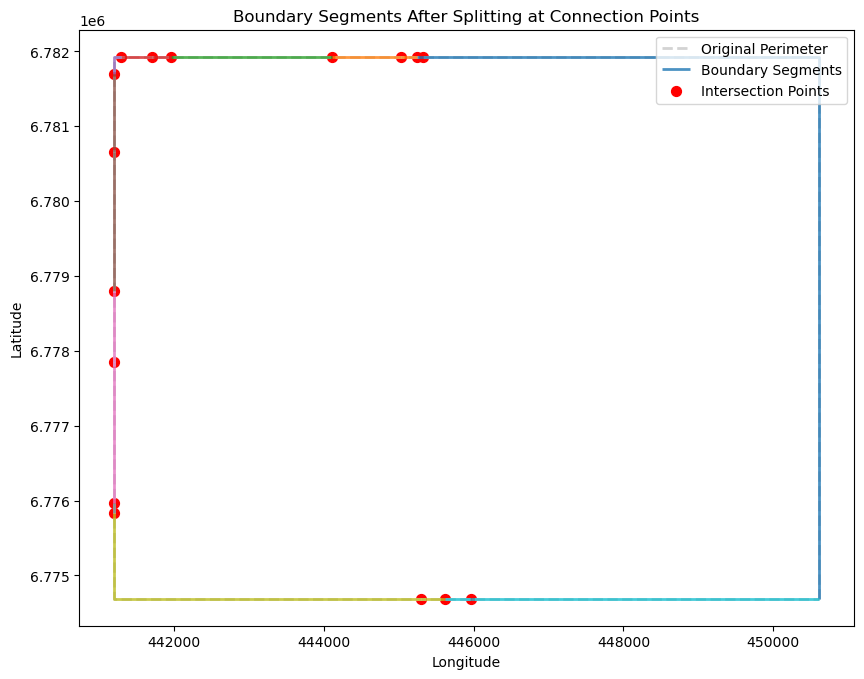

In [18]:
# Splitting Chart Boundary at Intersection Points Script
#
# This script takes a chart boundary (Polygon) and a set of sorted intersection points,
# converts the boundary to a LineString, and splits it at the given points.
# The resulting segments are saved into a GeoPackage and visualized.
#
# Inputs:
#   - chart_limit_file: Path to the GeoPackage containing the chart boundary (Polygon).
#   - intersection_points_file: Path to the GeoPackage containing sorted intersection points.
#
# Outputs:
#   - output_geojson: GeoPackage containing the split boundary as individual LineStrings.
#   - A visualization of the original perimeter, split segments, and intersection points.
#
# Method:
#   - split_chart_boundary_at_intersections()

import geopandas as gpd
from shapely.geometry import LineString, MultiPoint
from shapely.ops import split
import matplotlib.pyplot as plt
import os

def split_chart_boundary_at_intersections(chart_limit_file, intersection_points_file, output_geojson):
    """
    Splits the chart boundary at intersection points and saves the resulting LineStrings.

    :param chart_limit_file: Path to the GeoPackage containing the chart boundary (Polygon).
    :param intersection_points_file: Path to the GeoPackage containing sorted intersection points.
    :param output_geojson: Path to save the output GeoPackage containing split boundary segments.
    """
    
    # Load the chart boundary (perimeter)
    chart_gdf = gpd.read_file(chart_limit_file)

    # Load the sorted intersection points
    points_gdf = gpd.read_file(intersection_points_file)

    # Extract the perimeter Polygon (assuming there's only one geometry)
    perimeter_polygon = chart_gdf.geometry.iloc[0]

    # Convert the Polygon boundary into a LineString
    perimeter = LineString(perimeter_polygon.exterior.coords)

    # Convert sorted points into a MultiPoint object
    split_points = MultiPoint(points_gdf.geometry)

    # Split the LineString at the intersection points
    split_segments = split(perimeter, split_points)

    # Convert split segments into a GeoDataFrame
    lines_gdf = gpd.GeoDataFrame(geometry=[seg for seg in split_segments.geoms], crs=chart_gdf.crs)

    # Save to a GeoPackage
    if os.path.exists(output_geojson):
        os.remove(output_geojson)

    lines_gdf.to_file(output_geojson, driver='GeoJSON')
    print(f"Boundary segments saved to {output_geojson}")

    # Visualization
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the original boundary in light gray (as dashed lines)
    gpd.GeoSeries([perimeter]).plot(ax=ax, color='lightgray', linewidth=2, linestyle='dashed', label='Original Perimeter')

    # Plot the split segments in different colors
    lines_gdf.plot(ax=ax, cmap='tab10', linewidth=2, alpha=0.8, label='Boundary Segments')

    # Plot the intersection points
    points_gdf.plot(ax=ax, color='red', marker='o', markersize=50, label='Intersection Points')

    # Customize the plot
    ax.set_title("Boundary Segments After Splitting at Connection Points")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend()

    plt.show()

# Example Execution
chart_limit_file = './output/Chart_Features/chartlimit_utm.geojson'
intersection_points_file = './output/Chart_Features/independent_points_intersections_in_order.geojson'
output_geojson = './output/Chart_Features/connected_boundary_lines.geojson'

split_chart_boundary_at_intersections(chart_limit_file, intersection_points_file, output_geojson)


Merging Clipped Shoreline with Split Chart Limits started
Geometry types in shoreline_clip_gdf:
LineString    1539
Name: count, dtype: int64
Geometry types in split_chartlimits_gdf:
LineString    17
Name: count, dtype: int64
Merging the two GeoDataFrames...
Ensuring geometries are valid and not empty...
Number of features in shoreline_clip_gdf: 1539
Number of features in split_chartlimits_gdf: 17
Total features after merging: 1556
Geometry types in merged_gdf:
LineString    1556
Name: count, dtype: int64
Merged GeoDataFrame saved to ./output/Land_Features/merged_landboundary.geojson


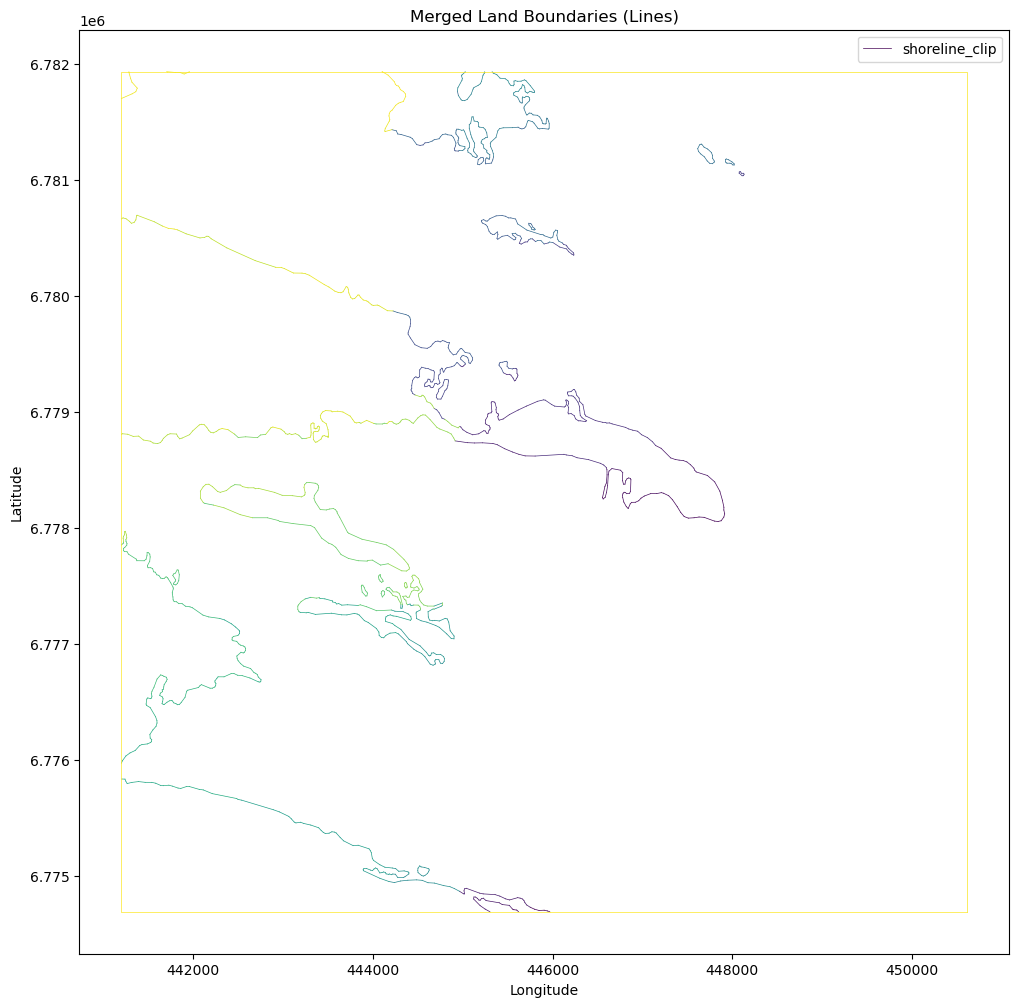

Merging Clipped Shoreline with Split Chart Limits completed in 1.10 seconds


In [19]:
# Merging Clipped Shoreline with Split Chart Limits Script
#
# This script merges two GeoDataFrames: one containing a clipped shoreline and the other containing split chart limits.
# It ensures CRS consistency, validates geometries, and saves the combined result into a new GeoPackage. 
# The script also visualizes the merged line geometries, providing a unified view of the land boundaries.
#
# Inputs:
#   - shoreline_clip_file: Path to the GeoPackage containing the clipped shoreline geometries.
#   - split_chartlimits_file: Path to the GeoPackage containing the split chart limits.
#   - crs: The target Coordinate Reference System (CRS) for the geometries.
#
# Outputs:
#   - merged_landboundary_geojson: GeoPackage containing the merged shoreline and chart limit geometries.
#   - A plot visualizing the merged land boundary lines.
#
# Method:
#   - merge_shorlineclip_with_splitchatlimits()
#
# Reference:
#   - https://github.com/umap-iic/UMap/blob/310d08604aeba3592c50e85dd5eb80ae218459cd/UMap.py#L2275


import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import time

# Input files
shoreline_clip_file = './output/Land_Features/shoreline_clip_with_chartlimit_utm.geojson'
split_chartlimits_file = './output/Chart_Features/connected_boundary_lines.geojson'  # Created previously
merged_landboundary_geojson = './output/Land_Features/merged_landboundary.geojson'

# Start task
print(f"Merging Clipped Shoreline with Split Chart Limits started")
start_time = time.time()

# Load the datasets
shoreline_clip_gdf = gpd.read_file(shoreline_clip_file)
split_chartlimits_gdf = gpd.read_file(split_chartlimits_file)

# --- Check geometry types ---
print("Geometry types in shoreline_clip_gdf:")
print(shoreline_clip_gdf['geometry'].geom_type.value_counts())

print("Geometry types in split_chartlimits_gdf:")
print(split_chartlimits_gdf['geometry'].geom_type.value_counts())

# Since both GeoDataFrames contain LineStrings, we can merge them directly
# Add source column to each GeoDataFrame
shoreline_clip_gdf['source'] = 'shoreline_clip'
split_chartlimits_gdf['source'] = 'split_chartlimits'

# Merging the two GeoDataFrames
print("Merging the two GeoDataFrames...")
merged_gdf = pd.concat([shoreline_clip_gdf, split_chartlimits_gdf], ignore_index=True)

# Reset index to ensure uniqueness
merged_gdf.reset_index(drop=True, inplace=True)

# Ensure the geometries are valid and not empty
print("Ensuring geometries are valid and not empty...")
merged_gdf = merged_gdf[merged_gdf.is_valid & ~merged_gdf.is_empty]

# Check the merge
print(f"Number of features in shoreline_clip_gdf: {len(shoreline_clip_gdf)}")
print(f"Number of features in split_chartlimits_gdf: {len(split_chartlimits_gdf)}")
print(f"Total features after merging: {len(merged_gdf)}")

# Check geometry types in merged_gdf
print("Geometry types in merged_gdf:")
print(merged_gdf['geometry'].geom_type.value_counts())

# Save the merged GeoDataFrame
if os.path.exists(merged_landboundary_geojson):
    os.remove(merged_landboundary_geojson)
merged_gdf.to_file(merged_landboundary_geojson, driver="GeoJSON")
print(f"Merged GeoDataFrame saved to {merged_landboundary_geojson}")

# Plot the result
fig, ax = plt.subplots(figsize=(12, 12))

# Assign colors to each line based on an attribute or index
num_features = len(merged_gdf)
colors = plt.cm.viridis(np.linspace(0, 1, num_features))

for idx, (geom, source) in enumerate(zip(merged_gdf['geometry'], merged_gdf['source'])):
    if geom.geom_type == 'LineString':  # Handle LineString
        x, y = geom.xy
        ax.plot(x, y, color=colors[idx], linewidth=0.5, label=source if idx == 0 else "")
    elif geom.geom_type == 'MultiLineString':  # Handle MultiLineString
        for line in geom.geoms:  # Use .geoms to iterate over individual LineStrings
            x, y = line.xy
            ax.plot(x, y, color=colors[idx], linewidth=0.5, label=source if idx == 0 else "")

# Add legend and labels
ax.set_title("Merged Land Boundaries (Lines)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.legend(loc='upper right')
plt.show()

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Merging Clipped Shoreline with Split Chart Limits completed in {elapsed_time:.2f} seconds")

Merged boundary GeoDataFrame loaded successfully.
GeoDataFrame is valid. Proceeding with polygonization.
Unified geometry created.
Polygonization completed. 3721 polygons created.
Geometries reprojected for accurate area calculations.
Five largest polygons identified.
Five largest polygons saved to ./output/Land_Features/five_largest_polygons.gpkg
Polygon 1 plotted.
Polygon 2 plotted.
Polygon 3 plotted.
Polygon 4 plotted.
Polygon 5 plotted.
Bathymetry raster plotted.


C:\Users\ndyer\AppData\Local\Temp\ipykernel_5664\4181885749.py:74: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
C:\Users\ndyer\AppData\Local\Temp\ipykernel_5664\4181885749.py:74: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


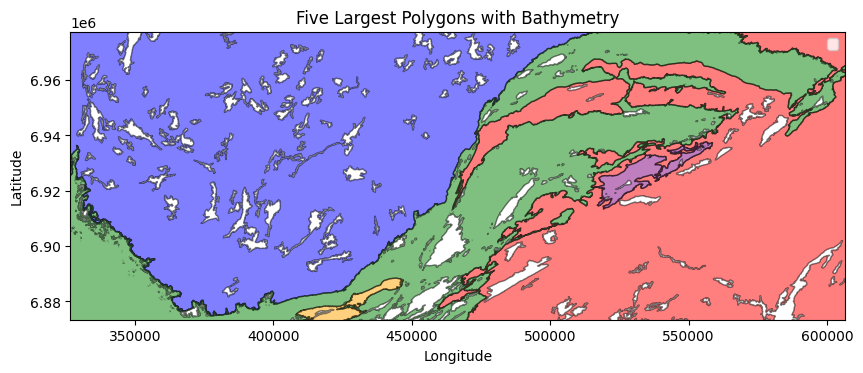

Displaying the plot...


In [7]:
### UTILITY CODE TO SHOW THE 5 LARGEST POYGONS

import os
import geopandas as gpd
import rasterio
import rasterio.plot
from shapely.ops import polygonize, unary_union
import matplotlib.pyplot as plt

# Step 1: Read the merged boundary GeoDataFrame from the previous step
merged_result_geojson = './output/Land_Features/merged_landboundary.geojson'  # Input from the previous task
merged_gdf = gpd.read_file(merged_result_geojson)

print("Merged boundary GeoDataFrame loaded successfully.")

# Step 2: Ensure the GeoDataFrame is not empty and has valid geometries
if merged_gdf.empty:
    print("Error: Merged GeoDataFrame is empty. Cannot proceed with polygonization.")
else:
    if not merged_gdf.is_valid.all():
        print("Error: Merged GeoDataFrame contains invalid geometries. Cannot proceed.")
    else:
        print("GeoDataFrame is valid. Proceeding with polygonization.")

        # Step 3: Create a unified geometry from all merged features
        unified_geom = unary_union(merged_gdf['geometry'])
        print("Unified geometry created.")

        # Step 4: Polygonize the unified geometry
        polygons = list(polygonize(unified_geom))
        print(f"Polygonization completed. {len(polygons)} polygons created.")

        if not polygons:
            print("Error: Polygonization resulted in an empty sequence of polygons.")
        else:
            # Create a GeoDataFrame for the polygonized results
            polygon_gdf = gpd.GeoDataFrame(geometry=polygons, crs=merged_gdf.crs)

            # Step 5: For accurate area calculation, reproject 
            projected_gdf = polygon_gdf.to_crs(projected_coord_system)
            print("Geometries reprojected for accurate area calculations.")

            # Calculate the area of each polygon
            projected_gdf['area'] = projected_gdf['geometry'].area.round(0)

            # Step 6: Identify the five largest polygons
            largest_polygons_gdf = projected_gdf.nlargest(5, 'area')
            print("Five largest polygons identified.")
            
            # Save the five largest polygons
            five_largest_polygons_path = './output/Land_Features/five_largest_polygons.geojson'
            if os.path.exists(five_largest_polygons_path):
                os.remove(five_largest_polygons_path)
            largest_polygons_gdf.to_file(five_largest_polygons_path, driver='GeoJSON')
            print(f"Five largest polygons saved to {five_largest_polygons_path}")

            # Step 7: Plot the polygons
            fig, ax = plt.subplots(figsize=(10, 10))
            colors = ['blue', 'red', 'green', 'purple', 'orange']
            
            for i, (index, row) in enumerate(largest_polygons_gdf.iterrows()):
                gpd.GeoSeries(row.geometry).plot(ax=ax, color=colors[i], edgecolor='black', alpha=0.5, label=f'Polygon {i+1}')
                print(f"Polygon {i+1} plotted.")

            # Step 8: Add bathymetry raster as an overlay
            bathymetry_raster_path = './output/Bathymetric_Features/reprojected_bathymetry.tif'
            with rasterio.open(bathymetry_raster_path) as src:
                rasterio.plot.show(src, ax=ax, cmap='Blues', alpha=1)
                print("Bathymetry raster plotted.")

            ax.set_title("Five Largest Polygons with Bathymetry")
            ax.set_xlabel("Longitude")
            ax.set_ylabel("Latitude")
            ax.legend()
            plt.show()
            print("Displaying the plot...")


Loading raster file...
Raster CRS: EPSG:32615, NoData Value: 3.4028234663852886e+38
Loading merged boundary polygons...
Merged boundary CRS: EPSG:32615
Merged boundary bounding box: [ 441199.  6774690.8  450611.  6781929.2]
Creating unified geometry and polygonizing...
Selecting the five largest polygons...
Bounding box of largest polygons: [ 441199.  6774690.8  450611.  6781929.2]
Polygon 2 contains the most sample points.
Identifying additional water polygons that do not touch the main water polygon...
Water and land areas separated successfully.
Saving output layers...
Saved: ./output/Bathymetric_Features/Bathymetric_Extent.geojson
Saved: ./output/Land_Features/Land_Area.geojson
Saved: ./output/Land_Features/shoreline_clip_polygon.geojson
Visualizing the results...


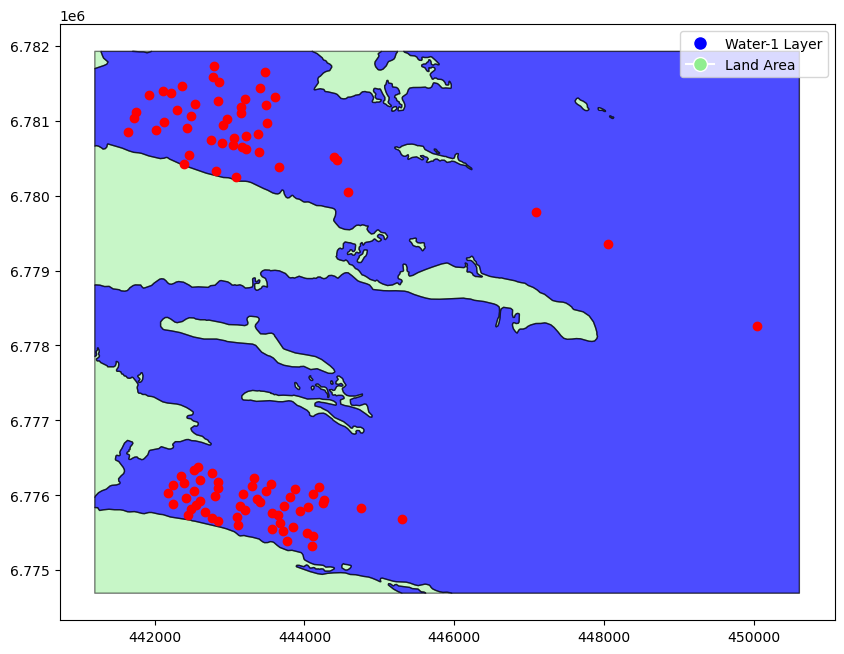

Processing complete.


In [20]:
# Polygonization of Merged Boundaries and Identification of Water and Land Areas -- NEW CODE
#
# This script processes merged boundary geometries, creates polygons from the unified geometry, 
# and identifies the **primary water body (Water-1)** based on the distribution of sampled bathymetric points.
# Instead of simply selecting the largest polygon, the script selects the **polygon that contains the most sampled depth points**.
# The remaining polygons are classified as land areas, saved into GeoPackages, and visualized on a map.
#
# Inputs:
#   - raster_path: Path to the bathymetric raster file (GeoTIFF format).
#   - merged_result_geojson: Path to the GeoPackage containing the merged boundary geometries.
#
# Outputs:
#   - water_1_layer_path: GeoPackage containing the identified water polygon.
#   - land_1_layer_path: GeoPackage containing the identified land areas.
#   - shoreline_clip_polygon_path: GeoPackage containing the combined land areas.
#   - A plot visualizing the separated water and land layers.
#
# Method:
#   - Loads and processes bathymetric raster data to extract valid depth values.
#   - Selects 100 sample bathymetric points ensuring even spatial distribution.
#   - Loads merged boundary polygons and polygonizes them to create distinct land/water areas.
#   - Identifies the five largest polygons based on area.
#   - Determines the **primary water body** by selecting the polygon that contains the highest number of sampled bathymetric points.
#     (The selected water polygon is **not necessarily the largest polygon**, but the one with the most bathymetric points.)
#   - Saves the identified **water and land areas** into separate GeoPackages.
#   - Generates a visualization of the land and water polygons along with the sampled depth points.


import os
import geopandas as gpd
import rasterio
import numpy as np
from shapely.geometry import Point
from shapely.ops import polygonize, unary_union
import matplotlib.pyplot as plt
from collections import Counter

# Load the raster file
raster_path = './output/Bathymetric_Features/reprojected_bathymetry.tif'
print("Loading raster file...")
with rasterio.open(raster_path) as src:
    band1 = src.read(1)  # Read the first band
    transform = src.transform  # Affine transformation for pixel to world
    raster_crs = src.crs
    nodata_value = src.nodata
    print(f"Raster CRS: {raster_crs}, NoData Value: {nodata_value}")

    # Find 100 valid pixels with considerable distance, excluding NoData values
    valid_pixels = np.argwhere((band1 < 0) & (~np.isnan(band1)) & (band1 != nodata_value))
    if valid_pixels.shape[0] < 100:
        raise ValueError("Not enough valid bathymetric data found in the raster.")
    
    step = max(1, len(valid_pixels) // 100)  # Ensure spacing between selected pixels
    sample_pixels = valid_pixels[::step][:100]  # Select every step-th pixel to maximize spacing
    sample_points = []
    sample_values = []
    for row, col in sample_pixels:
        x, y = rasterio.transform.xy(transform, row, col)  # Convert to world coordinates
        value = band1[row, col]
        sample_points.append(Point(x, y))
        sample_values.append(value)
    #print(f"Selected sample pixels with values (excluding NoData): {[ (p.x, p.y, v) for p, v in zip(sample_points, sample_values) ]}")

# Load merged boundary polygons
merged_result_geojson = './output/Land_Features/merged_landboundary.geojson'
print("Loading merged boundary polygons...")
merged_gdf = gpd.read_file(merged_result_geojson)
print(f"Merged boundary CRS: {merged_gdf.crs}")
print(f"Merged boundary bounding box: {merged_gdf.total_bounds}")

if merged_gdf.empty or not merged_gdf.is_valid.all():
    raise ValueError("Error: Invalid or empty merged boundary geometries.")

# Create unified geometry and polygonize
print("Creating unified geometry and polygonizing...")
unified_geom = unary_union(merged_gdf['geometry'])
polygons = list(polygonize(unified_geom))
polygon_gdf = gpd.GeoDataFrame(geometry=polygons, crs=merged_gdf.crs)

# Sort polygons by descending area and select top 5
print("Selecting the five largest polygons...")
polygon_gdf['area'] = polygon_gdf['geometry'].area
largest_polygons = polygon_gdf.nlargest(5, 'area')
print(f"Bounding box of largest polygons: {largest_polygons.total_bounds}")

# Find which polygon contains the most sample points
polygon_count = Counter()
for point in sample_points:
    for index, row in largest_polygons.iterrows():
        if row['geometry'].contains(point):
            polygon_count[index] += 1

# Select the polygon containing the most sample points
selected_water_polygon_index = polygon_count.most_common(1)[0][0] if polygon_count else None
if selected_water_polygon_index is None:
    raise ValueError("None of the sample points are contained in the top 5 polygons.")

selected_water_polygon = largest_polygons.loc[selected_water_polygon_index, 'geometry']
print(f"Polygon {selected_water_polygon_index} contains the most sample points.")

# Identify initial water polygon
water_gdf = polygon_gdf[polygon_gdf['geometry'] == selected_water_polygon]

# Identify non-water polygons
land_gdf = polygon_gdf[polygon_gdf['geometry'] != selected_water_polygon]

# Identify additional water polygons: those that do NOT touch the identified water polygon
print("Identifying additional water polygons that do not touch the main water polygon...")
additional_water_polygons = land_gdf[~land_gdf['geometry'].touches(selected_water_polygon)]

# Update water and land classifications
water_gdf = pd.concat([water_gdf, additional_water_polygons])
land_gdf = land_gdf[~land_gdf.index.isin(additional_water_polygons.index)]

#Dissolve Holes
water_gdf["geometry"] = water_gdf["geometry"].buffer(0)
land_gdf["geometry"] = land_gdf["geometry"].buffer(0)

print("Water and land areas separated successfully.")

# Save output layers
print("Saving output layers...")
water_1_layer_path = './output/Bathymetric_Features/Bathymetric_Extent.geojson'
land_1_layer_path = './output/Land_Features/Land_Area.geojson'
shoreline_clip_polygon_path = './output/Land_Features/shoreline_clip_polygon.geojson'

for path, gdf in [(water_1_layer_path, water_gdf), (land_1_layer_path, land_gdf), (shoreline_clip_polygon_path, land_gdf)]:
    if os.path.exists(path):
        os.remove(path)
    gdf.to_file(path, driver='GeoJSON')
    print(f"Saved: {path}")

# Visualization
print("Visualizing the results...")
fig, ax = plt.subplots(figsize=(10, 10))
land_gdf.plot(ax=ax, color='lightgreen', edgecolor='black', alpha=0.5, label='Land Area')
water_gdf.plot(ax=ax, color='blue', edgecolor='black', alpha=0.7, label='Water-1 Layer')
plt.scatter([p.x for p in sample_points], [p.y for p in sample_points], color='red', label='Sample Pixels', zorder=3)
ax.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', label='Water-1 Layer',
               markerfacecolor='blue', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Land Area',
               markerfacecolor='lightgreen', markersize=10)
])
plt.show()
print("Processing complete.")
